In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image,ImageOps 
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn import model_selection
import seaborn as sns
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [3]:
!wget http://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip

--2022-06-03 12:27:14--  http://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip
Resolving mrl.cs.vsb.cz (mrl.cs.vsb.cz)... 158.196.141.22
Connecting to mrl.cs.vsb.cz (mrl.cs.vsb.cz)|158.196.141.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341866898 (326M) [application/zip]
Saving to: ‘mrlEyes_2018_01.zip’

mrlEyes_2018_01.zip 100%[===================>] 326.03M  7.17MB/s    in 46s     

2022-06-03 12:28:00 (7.14 MB/s) - ‘mrlEyes_2018_01.zip’ saved [341866898/341866898]



In [4]:
!unzip mrlEyes_2018_01 && rm mrlEyes_2018_01.zip
!mkdir /content/data
for i in os.listdir('mrlEyes_2018_01'):
  if(i[:2]=='s0'):
    minifolder='/content/mrlEyes_2018_01/'+i
    os.chdir(minifolder)
    filename='/content/data/'+i+'.zip'
    !zip -m '$filename' *

Streaming output truncated to the last 5000 lines.
  adding: s0036_06027_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06028_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06029_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06030_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06031_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06032_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06033_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06034_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06035_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06036_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06037_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06038_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06039_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06040_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06041_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06042_1_1_1_2_0_01.png (stored 0%)
  adding: s0036_06043_1_1_1_0_0_01.png (stored 0%)
  adding: s0036_06044_1_1_1_2_0_01.png (stored 0%)
  adding: s0036_06045_1_1_1_0_0

In [5]:
os.chdir('/content/data')
!cat s0* > eyes_temp.zip
!zip -FF eyes_temp.zip --out data.zip

!rm s0*

!unzip data.zip && rm data.zip
!rm eyes_temp.zip

Streaming output truncated to the last 5000 lines.
 extracting: s0037_05258_1_1_0_0_1_01.png  
 extracting: s0037_05259_1_1_0_0_0_01.png  
 extracting: s0037_05260_1_1_0_0_0_01.png  
 extracting: s0037_05261_1_1_0_0_0_01.png  
 extracting: s0037_05262_1_1_0_0_1_01.png  
 extracting: s0037_05263_1_1_0_0_1_01.png  
 extracting: s0037_05264_1_1_0_0_0_01.png  
 extracting: s0037_05265_1_1_0_0_1_01.png  
 extracting: s0037_05266_1_1_0_0_0_01.png  
 extracting: s0037_05267_1_1_0_0_0_01.png  
 extracting: s0037_05268_1_1_0_0_0_01.png  
 extracting: s0037_05269_1_1_0_0_0_01.png  
 extracting: s0037_05270_1_1_0_0_0_01.png  
 extracting: s0037_05271_1_1_0_0_0_01.png  
 extracting: s0037_05272_1_1_0_0_0_01.png  
 extracting: s0037_05273_1_1_0_0_0_01.png  
 extracting: s0037_05274_1_1_0_0_0_01.png  
 extracting: s0037_05275_1_1_0_0_0_01.png  
 extracting: s0037_05276_1_1_0_0_0_01.png  
 extracting: s0037_05277_1_1_0_2_1_01.png  
 extracting: s0037_05278_1_1_0_0_0_01.png  
 extracting: s0037_05279_

In [6]:
os.listdir('/content/data')[:10]

['s0014_08310_0_0_1_0_1_02.png',
 's0016_00978_1_0_0_0_1_01.png',
 's0019_05523_0_0_1_0_0_01.png',
 's0037_06379_1_0_1_0_0_01.png',
 's0037_02983_1_0_0_0_0_01.png',
 's0014_03968_0_0_1_0_0_01.png',
 's0012_07181_0_0_1_0_1_01.png',
 's0012_00285_0_0_0_0_0_01.png',
 's0013_02852_0_1_0_0_0_01.png',
 's0018_02350_0_1_0_0_0_01.png']

In [7]:
data=[]
label=[]
for i in os.listdir('/content/data'):
  image = Image.open(i)
  image=ImageOps.grayscale(image)
  image=image.resize((52,52))
  image=np.array(image)
  data.append(image)
  if(i[16]=='1'):
    label.append(1)
  else:
    label.append(0)

Data Analysis

In [8]:
len(data),len(label)

(84898, 84898)

In [9]:
df=pd.DataFrame(label,columns=['target'])
Close = df[df['target']==0]['target'].count()
Open = df[df['target']==1]['target'].count()
Open_percent = Open/(Open+Close)
Close_percent = Close/(Close+Open)
print('Total Number of Open Eyes:',Open)
print('Total Number of Close Eyes:',Close)
print('Percentage of Open Eyes:',Open_percent*100,'%')
print('Percentage of Close Eyes:',Close_percent*100,'%')

Total Number of Open Eyes: 42952
Total Number of Close Eyes: 41946
Percentage of Open Eyes: 50.592475676694384 %
Percentage of Close Eyes: 49.407524323305616 %


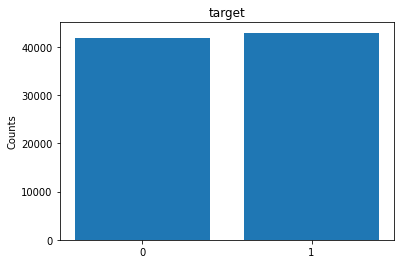

In [10]:
var = df['target']
count = var.value_counts()
plt.bar(count.index, count)
plt.xticks(count.index, count.index.values)
plt.ylabel("Counts")
plt.title('target')
plt.show()

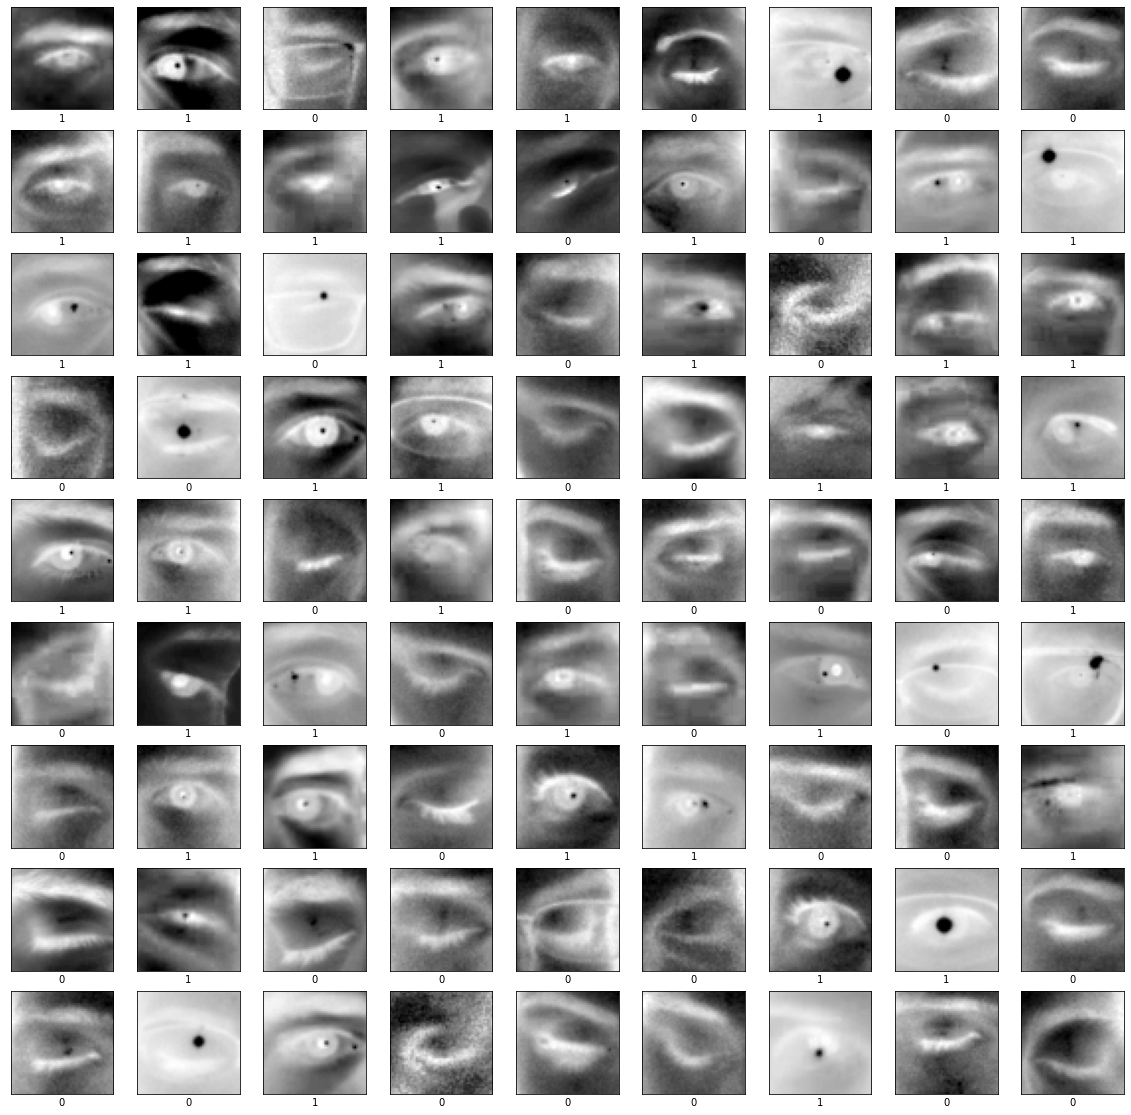

In [11]:
plt.figure(figsize=(20,20))
for i in range(81):
    plt.subplot(9,9,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[i+50],cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(label[i+50])
plt.show()

Data Preprocessing

In [12]:
data=np.array(data)
label=to_categorical(label)
print(data[0])
print(data.shape)
print(label.shape)

[[ 60  55  49 ... 163 166 169]
 [ 47  44  45 ... 159 160 163]
 [ 50  53  55 ... 148 156 158]
 ...
 [137 137 139 ... 172 172 168]
 [140 137 137 ... 171 173 170]
 [141 140 140 ... 172 176 173]]
(84898, 52, 52)
(84898, 2)


In [13]:
data=data/255.0

Model Building

In [14]:
train_images,test_images,train_labels,test_labels=model_selection.train_test_split(data,label,test_size=0.33,random_state=42)

In [15]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(56881, 52, 52)
(56881, 2)
(28017, 52, 52)
(28017, 2)


In [16]:
train_images=train_images.reshape(list(train_images.shape) + [1])
test_images=test_images.reshape(list(test_images.shape)+[1])
print(train_images.shape)
print(test_images.shape)

(56881, 52, 52, 1)
(28017, 52, 52, 1)


In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(52,52,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(2,activation='softmax'))

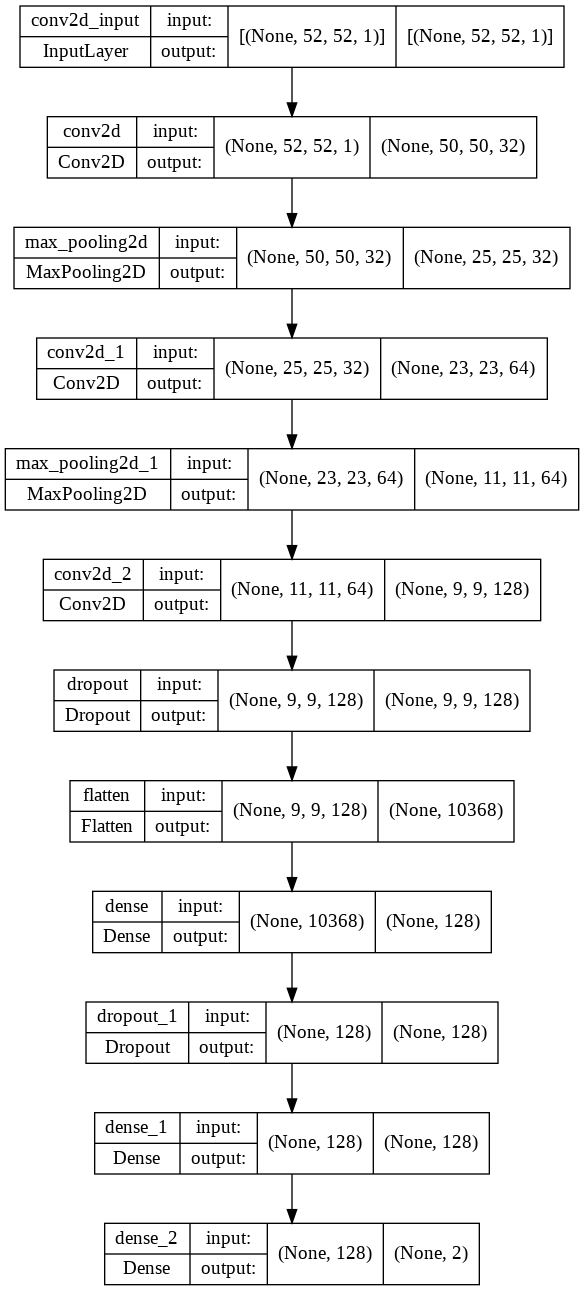

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 dropout (Dropout)           (None, 9, 9, 128)         0

In [21]:
history = model.fit(train_images, train_labels, epochs=15,batch_size=128,validation_data = (test_images,test_labels))

Epoch 1/15
445/445 [==============================] - 20s 19ms/step - loss: 0.2273 - accuracy: 0.9104 - val_loss: 0.0973 - val_accuracy: 0.9631
Epoch 2/15
445/445 [==============================] - 7s 17ms/step - loss: 0.0987 - accuracy: 0.9649 - val_loss: 0.0675 - val_accuracy: 0.9748
Epoch 3/15
445/445 [==============================] - 7s 17ms/step - loss: 0.0719 - accuracy: 0.9747 - val_loss: 0.0571 - val_accuracy: 0.9794
Epoch 4/15
445/445 [==============================] - 8s 18ms/step - loss: 0.0611 - accuracy: 0.9787 - val_loss: 0.0481 - val_accuracy: 0.9837
Epoch 5/15
445/445 [==============================] - 9s 21ms/step - loss: 0.0537 - accuracy: 0.9811 - val_loss: 0.0479 - val_accuracy: 0.9826
Epoch 6/15
445/445 [==============================] - 10s 22ms/step - loss: 0.0479 - accuracy: 0.9839 - val_loss: 0.0439 - val_accuracy: 0.9845
Epoch 7/15
445/445 [==============================] - 11s 25ms/step - loss: 0.0445 - accuracy: 0.9842 - val_loss: 0.0411 - val_accuracy: 0.9

Model Evaluation

In [22]:
model.evaluate(test_images,test_labels,batch_size=64)

438/438 [==============================] - 2s 4ms/step - loss: 0.0337 - accuracy: 0.9888


[0.033710166811943054, 0.9887568354606628]

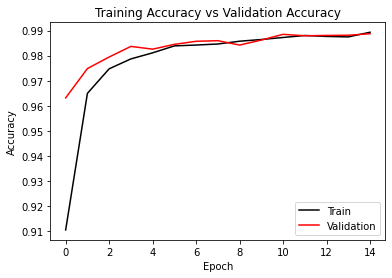

In [23]:
plt.plot(history.history['accuracy'], color='black',)
plt.plot(history.history['val_accuracy'], color='red',)
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

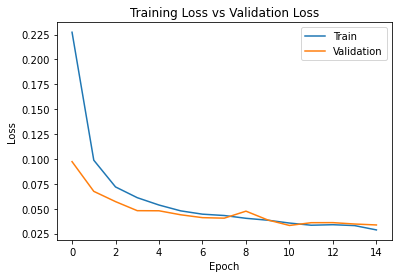

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [25]:
# Confusion Matrix

# Predict the values from the validation dataset
Y_pred = model.predict(test_images)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
confusion_mtx = pd.DataFrame(confusion_mtx , index = [i for i in range(2)] , columns = [i for i in range(2)])

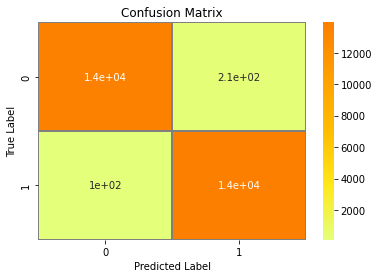

In [26]:
# plot the confusion matrix
sns.heatmap(confusion_mtx, annot=True, linewidths=1,cmap="Wistia",linecolor="gray")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [27]:
model.save('/content/model_CNN.h5', overwrite=True)